In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils.consensus_node import ConsensusNode
from utils.master_node import MasterNode

import wide_resnet_submodule.config as cf
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

from wide_resnet_submodule.networks import *

In [2]:
ABC_5 = {'Alice':   {'Alice': 0.5,  'Bob': 0.25, 'Charlie': 0.25},
         'Bob':     {'Alice': 0.25, 'Bob': 0.5,  'Charlie': 0.25},
         'Charlie': {'Alice': 0.25, 'Bob': 0.25, 'Charlie': 0.5}}

In [3]:
ABC_9 = {'Alice':   {'Alice': .9,   'Bob': 0.05, 'Charlie': 0.05},
         'Bob':     {'Alice': 0.05, 'Bob': .9,   'Charlie': 0.05},
         'Charlie': {'Alice': 0.05, 'Bob': 0.05, 'Charlie': .9}}

In [4]:
CYCLE4_5 = {'North': {'North': 0.5, 'East':  0.25, 'West':  0.25},
            'East':  {'East':  0.5, 'North': 0.25, 'South': 0.25},
            'South': {'South': 0.5, 'East':  0.25, 'West':  0.25},
            'West':  {'West':  0.5, 'South': 0.25, 'North': 0.25}}

In [5]:
FULL4_52 = {'North': {'North': 0.52, 'East':  0.16, 'West':  0.16, 'South': 0.16},
            'East':  {'East':  0.52, 'North': 0.16, 'South': 0.16, 'West':  0.16},
            'South': {'South': 0.52, 'East':  0.16, 'West':  0.16, 'North': 0.16},
            'West':  {'West':  0.52, 'South': 0.16, 'North': 0.16, 'East':  0.16}}

In [6]:
LONELY = {'Model': {'Model': 1.0}}

In [7]:
topology = ABC_9
n_agents = len(topology)

In [8]:
model_name = 'lenet'
num_classes = 10

if model_name == 'lenet':
    model = LeNet
    model_args = [num_classes]
elif model_name == 'vggnet':
    model = VGG
    model_args = [11, num_classes] # VGGnet depth should be either 11, 13, 16, 19
elif model_name == 'resnet':
    model = ResNet
    model_args = [18, num_classes] # Resnet depth should be either 18, 34, 50, 101, 152
elif model_name == 'wide-resnet':
    model = Wide_ResNet
    model_args = [16, 10, 0.3, num_classes] # depth, widen_factor, dropout (Wide-resnet depth should be 6n+4)
else:
    print('Error : Network should be either [Ann / LeNet / VGGNet / ResNet / Wide_ResNet')
    exit(0)

criterion = nn.CrossEntropyLoss
learning_rate = 0.02

optimizer = optim.SGD
optimizer_kwargs = {'momentum': 0.9, 'weight_decay': 5e-4}

In [9]:
# Hyper Parameter settings
start_epoch, num_epochs, batch_size, optim_type = cf.start_epoch, cf.num_epochs, cf.batch_size, cf.optim_type

In [10]:
dataset_name = 'cifar10'

In [11]:
# prepare dataset
if dataset_name == 'cifar10':
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ]) # meanstd transformation

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                            train=True, download=True,
                                            transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                           train=False, download=False,
                                           transform=transform_test)
   
    sizes = [len(trainset) // n_agents for i in range(n_agents)]
    sizes[-1] += len(trainset) % n_agents
    subsets = torch.utils.data.random_split(trainset, sizes)
    train_loaders = {node_name: torch.utils.data.DataLoader(subset,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       num_workers=2)
                for node_name, subset in zip(topology, subsets)
               }
    test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    
else:
    print("This dataset is not yet supported.")
    exit(0)

Files already downloaded and verified


In [12]:
num_epochs = 20

In [13]:
epoch_len = min(len(tl) for tl in train_loaders.values())
print(epoch_len)

131


In [14]:
# init master node
master = MasterNode(node_names=topology.keys(),
                    weights=topology, # param_a = a*param_a + b*param_b + c*param_c, where a + b + c = 1.0
                    train_loaders=train_loaders, # dict of train loaders, train_loaders[node_name] = train loader for node_name
                    test_loader=test_loader, # general test loader
                    stat_step=100, # save statistic each stat step 
                    epoch=num_epochs, # number of epochs
                    epoch_len=epoch_len, # length each epoch
                    epoch_cons_num=3, # the first epoch from which consensus begins
                    verbose=2
                   )

In [15]:
master.set_model(model, *model_args)

Master set model=<class 'wide_resnet_submodule.networks.lenet.LeNet'>, args=(10,), kwargs={}


In [16]:
master.set_optimizer(optimizer, optimizer_kwargs)

Master set optimizer=<class 'torch.optim.sgd.SGD'>, args=({'momentum': 0.9, 'weight_decay': 0.0005},), kwargs={}


In [17]:
master.set_error(criterion)

Master set error=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, args=(), kwargs={}


In [18]:
# init consensus nodes
master.initialize_nodes()

Node Alice set model=LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
) with args=(10,), kwargs={}
Node Alice set optimizer=<class 'torch.optim.sgd.SGD'> with args=({'momentum': 0.9, 'weight_decay': 0.0005},), kwargs={}
Node Alice set error=CrossEntropyLoss() with args=(), kwargs={}
Node Bob set model=LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
) with args=(10,), kwargs={}
Node Bob set optimizer=<class 'torch.optim.sgd.SGD'> with args=({'momentum': 0.9, 'weight_decay': 0

In [19]:
# for pretty outputs uncomment (if warnings)
# import warnings
# warnings.simplefilter(action='ignore', category=Warning)

In [20]:
master.start_consensus()
print('Done!')

Epoch: 1, Step: 100, Node Alice: accuracy 12.37, loss 230.10
Epoch: 1, Step: 100, Node Bob: accuracy 9.49, loss 230.23
Epoch: 1, Step: 100, Node Charlie: accuracy 14.83, loss 230.23
Epoch: 2, Step: 200, Node Alice: accuracy 19.92, loss 227.05
Epoch: 2, Step: 200, Node Bob: accuracy 14.76, loss 228.58
Epoch: 2, Step: 200, Node Charlie: accuracy 12.59, loss 229.65
Epoch: 3, Step: 300, Node Alice: accuracy 10.04, loss 221.26
Epoch: 3, Step: 300, Node Bob: accuracy 10.12, loss 226.33
Epoch: 3, Step: 300, Node Charlie: accuracy 10.00, loss 228.84
Epoch: 4, Step: 400, Node Alice: accuracy 14.35, loss 229.36
Epoch: 4, Step: 400, Node Bob: accuracy 14.71, loss 229.36
Epoch: 4, Step: 400, Node Charlie: accuracy 14.25, loss 229.31
Epoch: 4, Step: 500, Node Alice: accuracy 15.26, loss 225.05
Epoch: 4, Step: 500, Node Bob: accuracy 16.35, loss 225.46
Epoch: 4, Step: 500, Node Charlie: accuracy 15.13, loss 224.80
Epoch: 5, Step: 600, Node Alice: accuracy 19.54, loss 219.90
Epoch: 5, Step: 600, Node

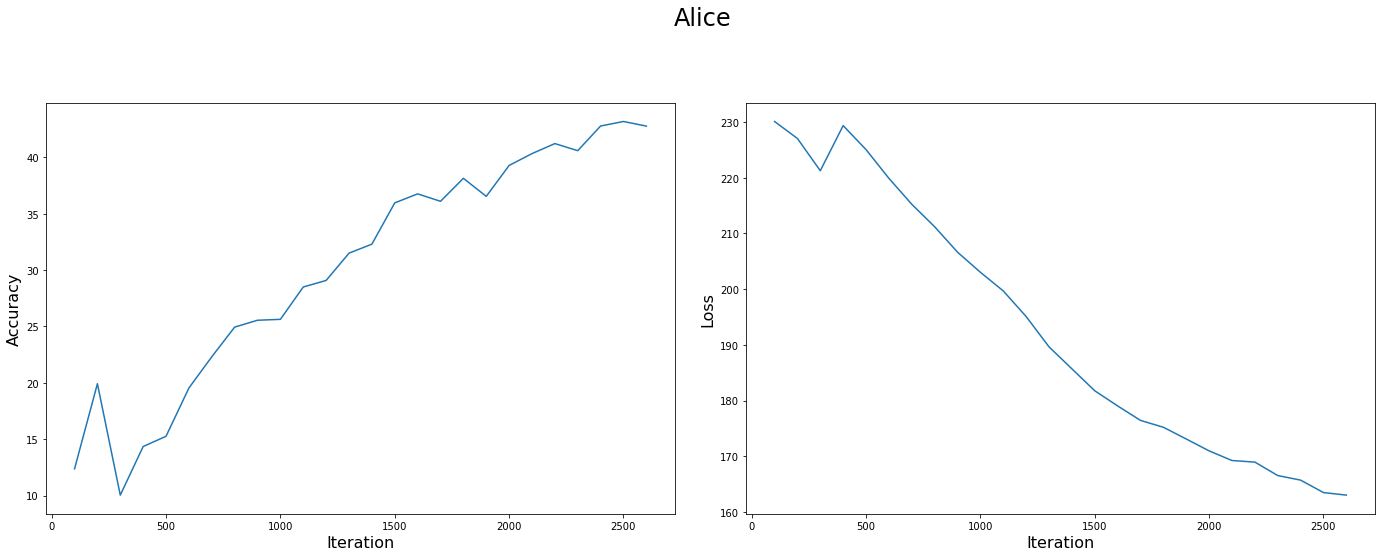

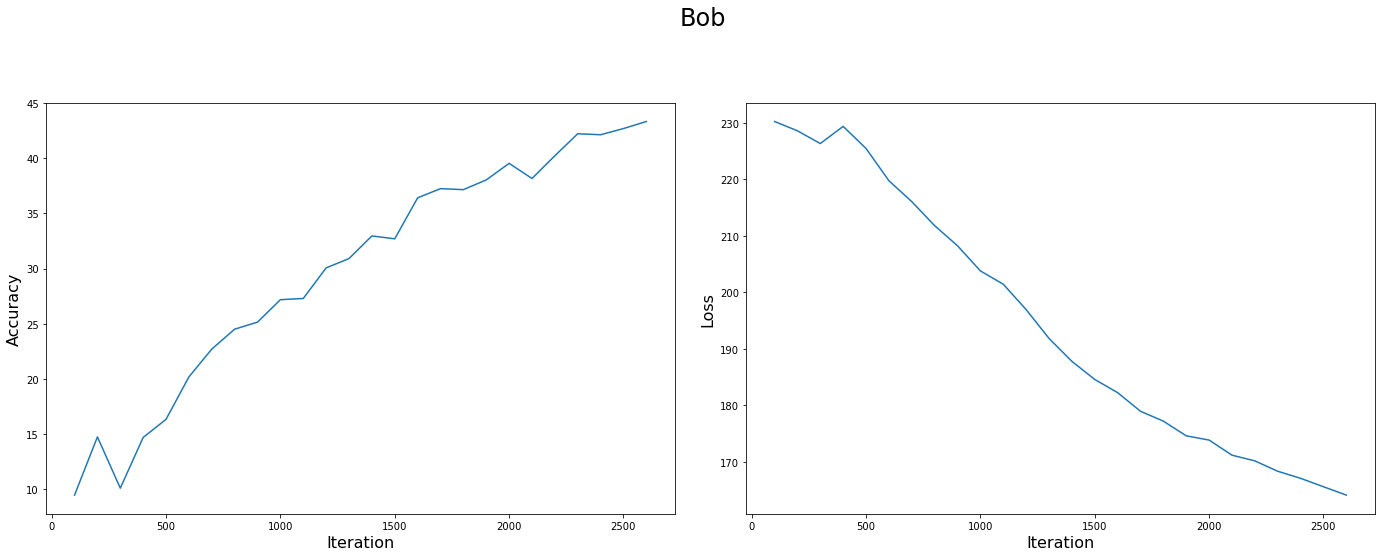

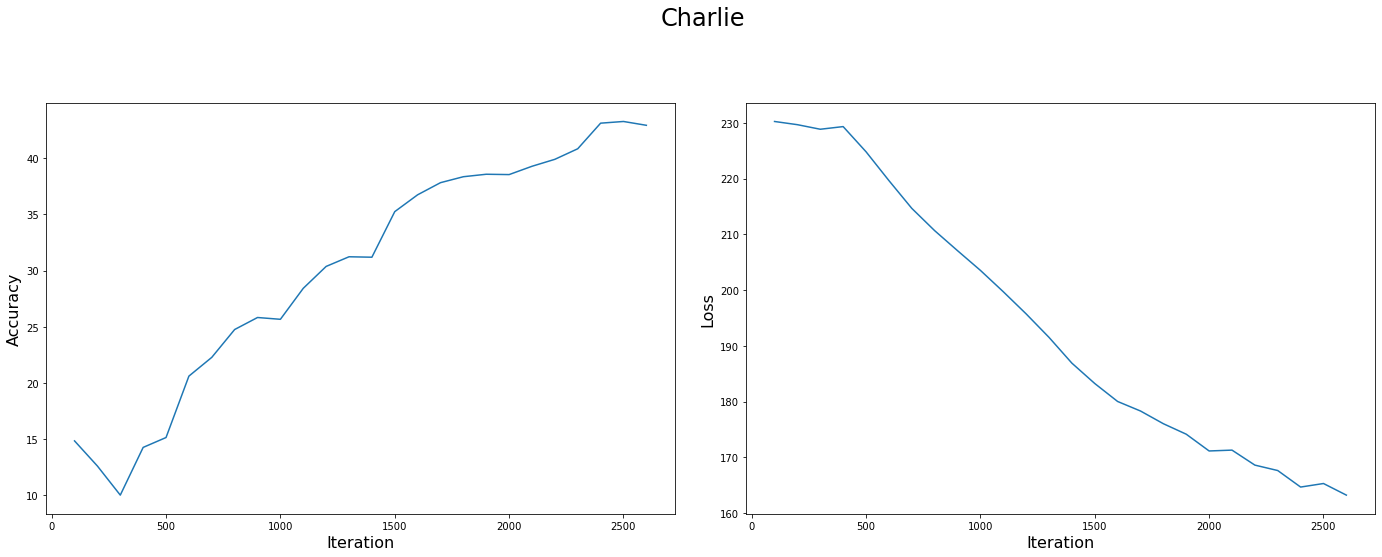

In [21]:
# Accuracy and loss plots for each node
for node in master.network.values():
    node.show_graphs()